# Configure pyspark session

In [ ]:
%%configure -f
{"executorMemory": "3G",
 "driverMemory":"5G",
 "executorCores": 1,
 "numExecutors": 30, 
 "conf": {"spark.dynamicAllocation.enabled": "false", 
          "spark.sql.parquet.enableVectorizedReader": "false", 
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type": "native",
          "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv"}}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
159,application_1681238170162_0159,pyspark,idle,Link,Link,None,


# Libraries

In [ ]:
from pyspark.sql.functions import sum, col, regexp_extract
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
sc.install_pypi_package("matplotlib")

In [ ]:
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Import Data

In [ ]:
raw = spark.read.load('s3://msbx5420-spr23/team_mba/accepted_2007_to_2018Q4.csv', 
                      format = 'csv', sep =',', 
                      inferSchema = 'true', header = 'true')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
161,application_1681238170162_0161,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# size of original data (rows, columns)
print((raw.count(), len(raw.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(2260701, 151)

In [ ]:
df = raw
print((df.count(), len(df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(2260701, 151)

# Handle Missing Values

In [ ]:
%%pretty
# view count of missing values by feature:
missing_values = df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# show the result
missing_values.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_mths_since_last_major_derog,disbursement_method,debt_settlement_flag
0,33,33,33,33,33,33,146940,33,37,33,33,33,34,35,34,1745,63,34,34,64,1158374,1901354,143,125,87,1867,83,50,54,46,44,42,36,36,35,39,36,76,68,201,1679686,99,88,2139788,2139829,2144839,221,70176,70204,866068,866092,866117,866124,909923,866133,1068859,866146,866142,866150,866374,70304,866155,866153,866161,50060,70376,74966,76103,432,258,139003,70225,70249,70271,50038,73425,1740974,295446,1520323,70297,70300,70307,58621,70307,70302,70302,70308,70307,58621,153689,70309,70307,70307,70463,75411,1637,338,70212,49981,50003,70271,2152654,2152660,2152655,2152665,2152667,2152671,2154514,2152678,2152678,2224757,288,226


In [ ]:
# drop the following extraneous/unnecessary/leakage features:
drop = ['member_id', 'emp_title', 'url', 'desc', 'title', 'issue_date', 'next_payment_d', 
        'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 
        'settlement_percentage', 'settlement_term', 'funded_amt', 'funded_amnt_inv', 'next_pymnt_d',
        'last_pymnt_d', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
        'hardship_flag', 'hardship_type', 'hardship_reason', 'deferral_term', 'hardship_amount',
        'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'grade', 'issue_d',
        'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest',
        'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'hardship_status',
        'sec_app_earliest_cr_line', 'earliest_cr_line', 'initial_list_status', 'last_credit_pull_d',
       ]
df = df.drop(*drop)
print((df.count(), len(df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(2260701, 114)

In [ ]:
# drop rows with missing values in the following features:
drop = ['revol_util', 'mort_acc', 'pub_rec_bankruptcies', 'dti', 'inq_last_6mths', 'open_acc',
        'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
        'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
        'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'purpose',
        'zip_code', 'policy_code', 'acc_now_delinq']
df = df.dropna(subset = drop)
print((df.count(), len(df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(2207227, 114)

In [ ]:
# replace missing employment length with '< 1 year'
# replace missing months since, etc columns with zero
df = df.fillna({'emp_length': '< 1 year', 'mths_since_last_delinq': 0, 'mths_since_last_record':0,
                'mths_since_last_major_derog':0, 'annual_inc_joint': 0, 'dti_joint':0,
                'verification_status_joint':'Not Verified', 'tot_coll_amt': 0,
                'tot_cur_bal':0, 'open_acc_6m':0, 'open_act_il':0, 'open_il_12m':0, 'open_il_24m':0,
                'mths_since_rcnt_il':0, 'total_bal_il':0, 'il_util':0, 'open_rv_12m':0,
                'open_rv_24m':0, 'max_bal_bc':0, 'all_util':0, 'total_rev_hi_lim':0, 'inq_fi':0,
                'total_cu_tl':0, 'acc_open_past_24mths':0, 'avg_cur_bal':0, 'bc_open_to_buy':0,
                'bc_util':0, 'mo_sin_old_il_acct':0, 'inq_last_12m':0, 'mo_sin_old_rev_tl_op':0,
                'mo_sin_rcnt_rev_tl_op':0, 'mo_sin_rcnt_tl':0, 'mths_since_recent_bc':0, 
                'mths_since_recent_bc_dlq':0, 'mths_since_recent_inq':0, 'mths_since_recent_revol_delinq':0,
                'num_accts_ever_120_pd':0, 'num_actv_bc_tl':0, 'num_actv_rev_tl':0, 'num_bc_sats':0,
                'num_bc_tl':0, 'num_il_tl':0, 'num_op_rev_tl':0, 'num_rev_accts':0, 
                'num_rev_tl_bal_gt_0':0, 'num_sats':0, 'num_tl_120dpd_2m':0, 'num_tl_30dpd':0,
                'num_tl_90g_dpd_24m':0, 'num_tl_op_past_12m':0, 'pct_tl_nvr_dlq':0, 'percent_bc_gt_75':0,
                'tot_hi_cred_lim':0, 'total_il_high_credit_limit':0, 'revol_bal_joint':0, 
                'sec_app_fico_range_low':0, 'sec_app_fico_range_high':0,
                'sec_app_inq_last_6mths':0, 'sec_app_mort_acc':0, 'sec_app_open_acc':0, 
                'sec_app_revol_util':0, 'sec_app_open_act_il':0, 'sec_app_num_rev_accts':0,
                'sec_app_mths_since_last_major_derog':0, 'disbursement_method':0})

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%pretty
missing_values = df.agg(*[(sum(col(c).isNull().cast("int")).alias(c)) for c in df.columns])
missing_values.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_mths_since_last_major_derog,disbursement_method,debt_settlement_flag
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print((df.count(), len(df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(2207227, 114)

# Data Analysis

In [ ]:
# separate databy loan_status into current, late, and default
current = df.filter(df.loan_status.isin(['Fully Paid', 'Current', 'In Grace Period']))
late = df.filter(df.loan_status.isin(['Late (31-120 days)', 'Late (16-30 days)']))
defaulted = df.filter(df.loan_status.isin(['Default', 'Charged Off']))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%pretty
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
68407277,null,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingcl...,null,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,null,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723916800001,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,null,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,null,null,null,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,null,null,null,null,null,null,null,null,null,null,null,null,null,N,null,null,null,null,null,null,null,null,null,null,null,null,null,null,Cash,N,null,null,null,null,null,null
68355089,null,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingcl...,null,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,null,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.66,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,null,Mar-2019,699.0,695.0,0.0,null,1.0,Individual,null,null,null,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,null,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,null,null,null,null,null,null,null,null

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

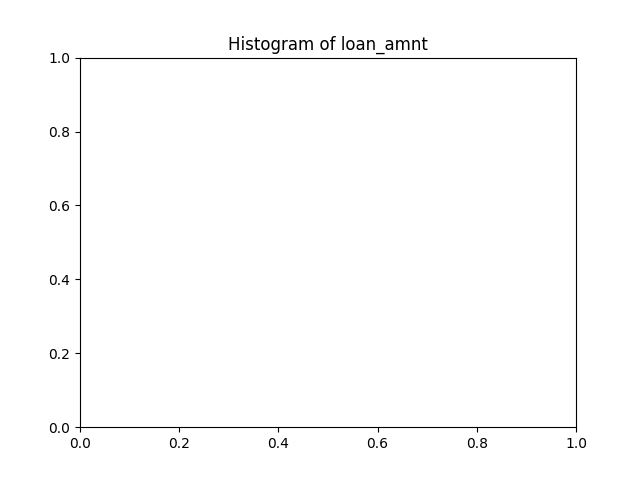

In [ ]:
# features to iterate over
features = ['loan_amnt']

# iterate over each feature
for feature in features:
    # create a histogram for the feature
    fig, ax = plt.subplots()
    current.select(feature).rdd.flatMap(lambda x: x).histogram(10)
    ax.set_title("Histogram of {}".format(feature))
    plt.show()
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

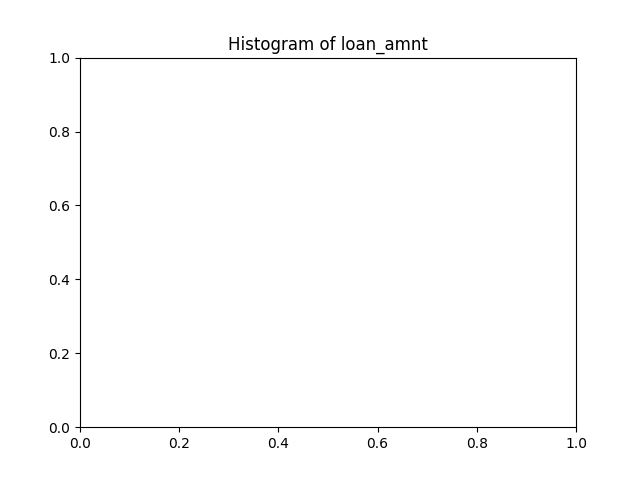

In [ ]:
# list of dataframes to iterate over
dataframes = [current, late, defaulted]

# features to plot histograms for
features = ['loan_amnt', 'grade']

# iterate over each feature
for dataframe in dataframes:
    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
histogram() got an unexpected keyword argument 'ax'
Traceback (most recent call last):
TypeError: histogram() got an unexpected keyword argument 'ax'



In [ ]:
for col in df.dtypes:
    print(col[0]+" , "+col[1])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id , string
member_id , string
loan_amnt , double
funded_amnt , double
funded_amnt_inv , double
term , string
int_rate , double
installment , double
grade , string
sub_grade , string
emp_title , string
emp_length , string
home_ownership , string
annual_inc , string
verification_status , string
issue_d , string
loan_status , string
pymnt_plan , string
url , string
desc , string
purpose , string
title , string
zip_code , string
addr_state , string
dti , string
delinq_2yrs , string
earliest_cr_line , string
fico_range_low , string
fico_range_high , string
inq_last_6mths , string
mths_since_last_delinq , string
mths_since_last_record , string
open_acc , string
pub_rec , string
revol_bal , string
revol_util , string
total_acc , string
initial_list_status , string
out_prncp , string
out_prncp_inv , string
total_pymnt , string
total_pymnt_inv , string
total_rec_prncp , string
total_rec_int , string
total_rec_late_fee , string
recoveries , string
collection_recovery_fee , string
last_pymnt_d ,

In [ ]:
def histogram(df, col, bins=10, xname=None, yname=None):
    
    '''
    This function makes a histogram from spark dataframe named 
    df for column name col. 
    '''
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    plt.bar(loc, vals[1], width=width)
    plt.xlabel(col)
    plt.ylabel(yname)
    plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dataframes = ['current', 'late', 'defaulted']
features = ['loan_amnt']

for dataframe in dataframes:
    for feature in features:
        histogram(current, feature, bins = 15, yname = feature)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

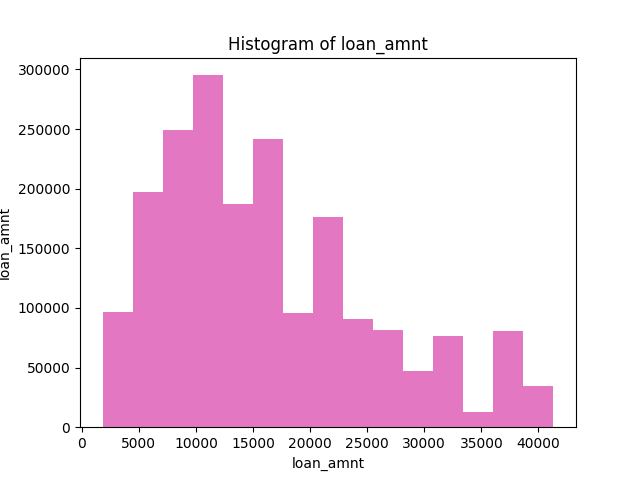

In [ ]:
%matplot plt